refer to https://www.pymc.io/projects/examples/en/latest/samplers/SMC-ABC_Lotka-Volterra_example.html

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc as pm
import pytensor.tensor as pt

print(f"Running on PyMC v{pm.__version__}")

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Running on PyMC v5.16.2


In [34]:
def wfpt(t, v, a, w=0.5, err=1e-6):
    """
    First passage time for Wiener diffusion model. Approximation based on
    Navarro & Fuss (2009).

    Parameters:
        t (array_like): Hitting time (e.g., response time in seconds)
        v (float): Drift rate
        a (float): Threshold
        w (float): Bias (default: 0.5)
        err (float): Error threshold (default: 1e-6)

    Returns:
        np.ndarray: Probability density
    """
    
    P = np.zeros_like(t, dtype=float)
    for i in range(len(t)):
        tt = t[i] / (a ** 2)  # Use normalized time
        
        # Calculate number of terms needed for large t
        if np.pi * tt * err < 1:  # If error threshold is set low enough
            kl = np.sqrt(-2 * np.log(np.pi * tt * err) / (np.pi ** 2 * tt))  # Bound
            kl = max(kl, 1 / (np.pi * np.sqrt(tt)))  # Ensure boundary conditions met
        else:  # If error threshold set too high
            kl = 1 / (np.pi * np.sqrt(tt))  # Set to boundary condition
        
        # Calculate number of terms needed for small t
        if 2 * np.sqrt(2 * np.pi * tt) * err < 1:  # If error threshold is set low enough
            ks = 2 + np.sqrt(-2 * tt * np.log(2 * np.sqrt(2 * np.pi * tt) * err))  # Bound
            ks = max(ks, np.sqrt(tt) + 1)  # Ensure boundary conditions are met
        else:  # If error threshold was set too high
            ks = 2  # Minimal kappa for that case
        
        # Compute f(tt|0,1,w)
        p = 0.0  # Initialize density
        if ks < kl:  # If small t is better...
            K = int(np.ceil(ks))  # Round to smallest integer meeting error
            for k in range(-int((K - 1) / 2), int(np.ceil((K - 1) / 2)) + 1):  # Loop over k
                p += (w + 2 * k) * np.exp(-((w + 2 * k) ** 2) / (2 * tt))  # Increment sum
            p /= np.sqrt(2 * np.pi * tt ** 3)  # Add constant term
        else:  # If large t is better...
            K = int(np.ceil(kl))  # Round to smallest integer meeting error
            for k in range(1, K + 1):
                p += k * np.exp(-(k ** 2) * (np.pi ** 2) * tt / 2) * np.sin(k * np.pi * w)  # Increment sum
            p *= np.pi  # Add constant term
        
        # Convert to f(t|v,a,w)
        P[i] = p * np.exp(-v * a * w - (v ** 2) * t[i] / 2) / (a ** 2)
    
    return P


In [10]:
def wfpt(t, v, a, w=0.5, err=1e-6):
    """
    First passage time for Wiener diffusion model. Approximation based on
    Navarro & Fuss (2009).

    Parameters:
        t (array_like): Hitting time (e.g., response time in seconds)
        v (float): Drift rate
        a (float): Threshold
        w (float): Bias (default: 0.5)
        err (float): Error threshold (default: 1e-6)

    Returns:
        np.ndarray: Probability density
    """
    

    tt = t / (a ** 2)  # Use normalized time
    # Calculate number of terms needed for large t
    if pm.math.gt(np.pi * tt * err,1):  # If error threshold is set low enough
        kl = pm.math.sqrt(-2 * np.log(np.pi * tt * err) / (np.pi ** 2 * tt))  # Bound
        kl = pm.math.max([kl, 1 / (np.pi * pm.math.sqrt(tt))])  # Ensure boundary conditions met
    else:  # If error threshold set too high
        kl = 1 / (np.pi * pm.math.sqrt(tt))  # Set to boundary condition
    # Calculate number of terms needed for small t
    if pm.math.gt(2 * np.sqrt(2 * np.pi * tt) * err,1):  # If error threshold is set low enough
        ks = 2 + pm.math.sqrt(-2 * tt * np.log(2 * pm.math.sqrt(2 * np.pi * tt) * err))  # Bound
        ks = pm.math.max([ks, pm.math.sqrt(tt) + 1])  # Ensure boundary conditions are met
    else:  # If error threshold was set too high
        ks = 2  # Minimal kappa for that case
    # Compute f(tt|0,1,w)
    p = 0.0  # Initialize density
    # if pm.math.gt(ks, kl):  # If small t is better...
    #     K = pm.math.ceil(ks)   # Round to smallest integer meeting error
    #     print(3)
    #     for k in range(-int((K - 1) / 2), int(pm.math.ceil((K - 1) / 2)) + 1):  # Loop over k
    #         p += (w + 2 * k) * pm.math.exp(-((w + 2 * k) ** 2) / (2 * tt))  # Increment sum
    #     p /= pm.math.sqrt(2 * np.pi * tt ** 3)  # Add constant term
    # else:  # If large t is better...
    #     K = pm.math.ceil(kl)   # Round to smallest integer meeting error
    #     for k in range(1, K + 1):
    #         p += k * pm.math.exp(-(k ** 2) * (np.pi ** 2) * tt / 2) * pm.math.sin(k * np.pi * w)  # Increment sum
    #     p *= np.pi  # Add constant term
    if pt.lt(ks, kl):  # If small t is better...
        K = pt.cast(pt.ceil(ks), 'int64')  # Round to smallest integer meeting error
        k_values = pt.arange(-pt.floor((K - 1) / 2), pt.ceil((K - 1) / 2) + 1)  # Generate k values
        # Vectorized computation
        p += (w + 2 * k_values) * pt.exp(-((w + 2 * k_values) ** 2) / (2 * tt))
        p = pt.sum(p)  # Sum over k values
        p /= pt.sqrt(2 * pt.pi * tt ** 3)  # Add constant term
    else:  # If large t is better...
        K = pt.cast(pt.ceil(kl), 'int64')  # Round to smallest integer meeting error
        k_values = pt.arange(1, K + 1)  # Generate k values
        # Vectorized computation
        p += k_values * pt.exp(-(k_values ** 2) * (pt.pi ** 2) * tt / 2) * pt.sin(k_values * pt.pi * w)
        p = pt.sum(p)  # Sum over k values
        p *= pt.pi  # Add constant term
    # Convert to f(t|v,a,w)
    P = p * pm.math.exp(-v * a * w - (v ** 2) * t / 2) / (a ** 2)
    
    return P


In [9]:
%%time
t = np.random.uniform(0, 5, 1000)
def logwfpt(t, v, a, w):
    return np.log(wfpt(t, v, a, w))+(1e-10)
with pm.Model() as model:
    v= pm.Normal("v", mu=4, sigma=0.1)
    a = pm.HalfNormal("a", sigma=1)
    w = pm.Uniform("w", lower=0.1, upper=0.9)
    ddm = pm.DensityDist("wfpt", 
                            v,
                            a,
                            w,
                            logp=logwfpt, 
                            observed=t)
    trace = pm.sample(2000, step=pm.Slice(), tune=2000)

ValueError: Input dimension mismatch: (input[%i].shape[%i] = %lld, input[%i].shape[%i] = %lld)
Apply node that caused the error: Composite{((i1 + i2 + (2.0 * i0)) * exp(((-0.5 * sqr((i1 + i2 + (2.0 * i0))) * i4) / i3)))}(ARange{dtype='float64'}.0, ExpandDims{axis=0}.0, ExpandDims{axis=0}.0, wfpt{[3.1775103 ... 33763e+00]}, Sqr.0)
Toposort index: 20
Inputs types: [TensorType(float64, shape=(None,)), TensorType(float64, shape=(1,)), TensorType(float64, shape=(1,)), TensorType(float64, shape=(1000,)), TensorType(float64, shape=(1,))]
Inputs shapes: [(13,), (1,), (1,), (1000,), (1,)]
Inputs strides: [(8,), (8,), (8,), (8,), (8,)]
Inputs values: ['not shown', array([0.45]), array([0.05]), 'not shown', array([1.])]
Outputs clients: [[Sum{axes=None}(Composite{((i1 + i2 + (2.0 * i0)) * exp(((-0.5 * sqr((i1 + i2 + (2.0 * i0))) * i4) / i3)))}.0)]]

HINT: Re-running with most PyTensor optimizations disabled could provide a back-trace showing when this node was created. This can be done by setting the PyTensor flag 'optimizer=fast_compile'. If that does not work, PyTensor optimizations can be disabled with 'optimizer=None'.
HINT: Use the PyTensor flag `exception_verbosity=high` for a debug print-out and storage map footprint of this Apply node.

array([[<Axes: title={'center': 'a'}>, <Axes: title={'center': 'a'}>],
       [<Axes: title={'center': 'v'}>, <Axes: title={'center': 'v'}>],
       [<Axes: title={'center': 'w'}>, <Axes: title={'center': 'w'}>]],
      dtype=object)

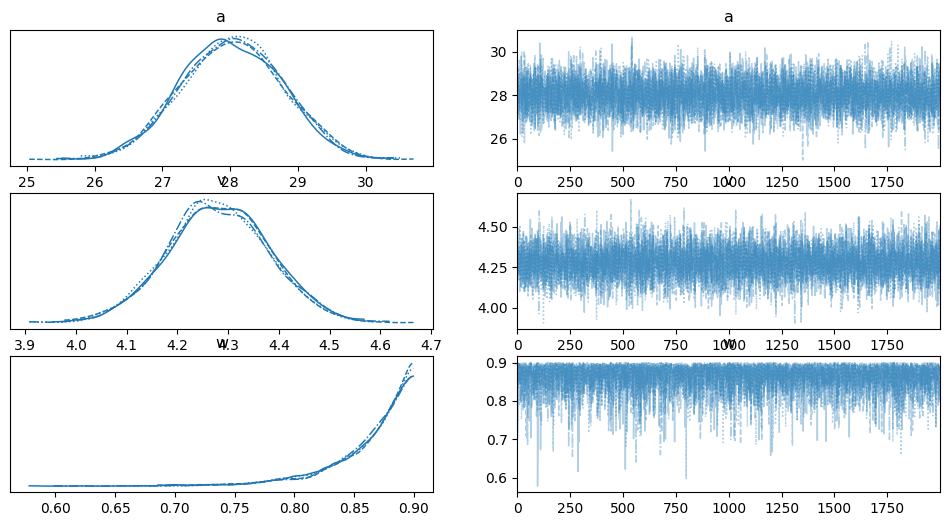

In [103]:
az.plot_trace(trace)